In [3]:
%%capture
%pip install torch
%pip install torchvision
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install scipy

In [4]:
%pip install git+https://github.com/KellerJordan/Muon

  Cloning https://github.com/KellerJordan/Muon to /private/var/folders/jk/_xl3d2hs5x36rpykc1vsg8m40000gq/T/pip-req-build-6hvv9gpe
  Running command git clone --filter=blob:none --quiet https://github.com/KellerJordan/Muon /private/var/folders/jk/_xl3d2hs5x36rpykc1vsg8m40000gq/T/pip-req-build-6hvv9gpe
  Resolved https://github.com/KellerJordan/Muon to commit f90a42b28e00b8d9d2d05865fe90d9f39abcbcbd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [5]:
from mm import PINNMuonOptimizer

# Importing data

In [48]:
print(T_DOMAIN, X_DOMAIN)

(np.float64(0.0), np.float64(0.25)) (np.float64(-0.2), np.float64(0.2))


In [6]:

import pickle
from pathlib import Path
from typing import Callable, Dict, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output, display
import math
from gauss_newton import GaussNewtonPINNOptimizer, GaussNewtonStepResult

def _select_device() -> torch.device:
    if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


DEVICE = _select_device()
DEFAULT_DTYPE = torch.float32 if DEVICE.type == "mps" else torch.float64
torch.set_default_dtype(DEFAULT_DTYPE)
torch.manual_seed(42)

DATA_DIR = Path("data1d")
PRIMITIVE_LABELS = ["rho", "vx", "vy", "vz", "By", "Bz", "p"]
RAW_FIELD_KEYS = ["rho", "u1", "u2", "u3", "b2", "b3", "p"]


def load_snapshots(data_dir: Path = DATA_DIR) -> Dict[float, Dict[str, np.ndarray]]:
    snapshots: Dict[float, Dict[str, np.ndarray]] = {}
    for path in sorted(data_dir.glob("data1D_t_*.pkl")):
        with open(path, "rb") as fh:
            payload = pickle.load(fh)
        time_value = float(payload["time"])
        x_grid = np.asarray(payload["x"], dtype=np.float64)
        fields = payload["fields"]
        primitives = np.stack(
            [np.asarray(fields[key], dtype=np.float64) for key in RAW_FIELD_KEYS],
            axis=1,
        )
        snapshots[time_value] = {"x": x_grid, "primitives": primitives}
    if not snapshots:
        raise RuntimeError(f"No snapshot files found in {data_dir}")
    return snapshots


SNAPSHOTS = load_snapshots()
AVAILABLE_TIMES = np.array(sorted(SNAPSHOTS.keys()), dtype=np.float64)
X_DOMAIN: Tuple[float, float] = (
    SNAPSHOTS[AVAILABLE_TIMES[0]]["x"][0],
    SNAPSHOTS[AVAILABLE_TIMES[0]]["x"][-1],
)
T_DOMAIN: Tuple[float, float] = (AVAILABLE_TIMES[0], AVAILABLE_TIMES[-1])


def _resolve_time_key(t: Union[float, torch.Tensor, np.ndarray]) -> float:
    t_scalar = float(t.detach().cpu().item() if isinstance(t, torch.Tensor) else np.asarray(t).item())
    matches = np.isclose(AVAILABLE_TIMES, t_scalar, atol=1e-12)
    if not np.any(matches):
        raise ValueError(
            f"Requested time {t_scalar} not found. Available times: {AVAILABLE_TIMES.tolist()}"
        )
    return float(AVAILABLE_TIMES[matches][0])


def _prepare_query(x: Union[float, np.ndarray, torch.Tensor]) -> Tuple[np.ndarray, Tuple[int, ...]]:
    if isinstance(x, torch.Tensor):
        arr = x.detach().cpu().numpy()
    else:
        arr = np.asarray(x, dtype=np.float64)
    arr = np.atleast_1d(arr).astype(np.float64)
    original_shape = tuple(arr.shape)
    return arr.reshape(-1), original_shape


def cond(
    t: Union[float, torch.Tensor, np.ndarray],
    x: Union[float, np.ndarray, torch.Tensor],
    *,
    device: torch.device = None,
    as_tensor: bool = True,
) -> Union[np.ndarray, torch.Tensor]:
    time_key = _resolve_time_key(t)
    snapshot = SNAPSHOTS[time_key]
    x_query, original_shape = _prepare_query(x)
    x_clipped = np.clip(x_query, snapshot["x"][0], snapshot["x"][-1])
    interpolated = np.vstack(
        [
            np.interp(x_clipped, snapshot["x"], snapshot["primitives"][:, i])
            for i in range(snapshot["primitives"].shape[1])
        ]
    ).T
    if original_shape == ():
        reshaped = interpolated.reshape(snapshot["primitives"].shape[1],)
    else:
        target_shape = original_shape[:-1] if original_shape and original_shape[-1] == 1 else original_shape
        reshaped = interpolated.reshape(target_shape + (snapshot["primitives"].shape[1],))
    if not as_tensor:
        return reshaped
    target_device = device or DEVICE
    return torch.as_tensor(reshaped, device=target_device, dtype=torch.get_default_dtype())


def plot_reference_profiles(times=(0.0, 0.036, 0.1), num_points=512):
    x_grid = np.linspace(X_DOMAIN[0], X_DOMAIN[1], num_points)
    profiles = {t: cond(t, x_grid, as_tensor=False) for t in times}
    fig, axes = plt.subplots(len(PRIMITIVE_LABELS), 1, figsize=(8, 14), sharex=True)
    for axis_idx, (ax, label) in enumerate(zip(axes, PRIMITIVE_LABELS)):
        for t in times:
            ax.plot(x_grid, profiles[t][..., axis_idx], label=f"t={t:.3f}")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel("x")
    axes[0].legend(loc="upper right", fontsize="small", ncols=len(times))
    fig.suptitle("Reference primitive profiles from data")
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    return fig


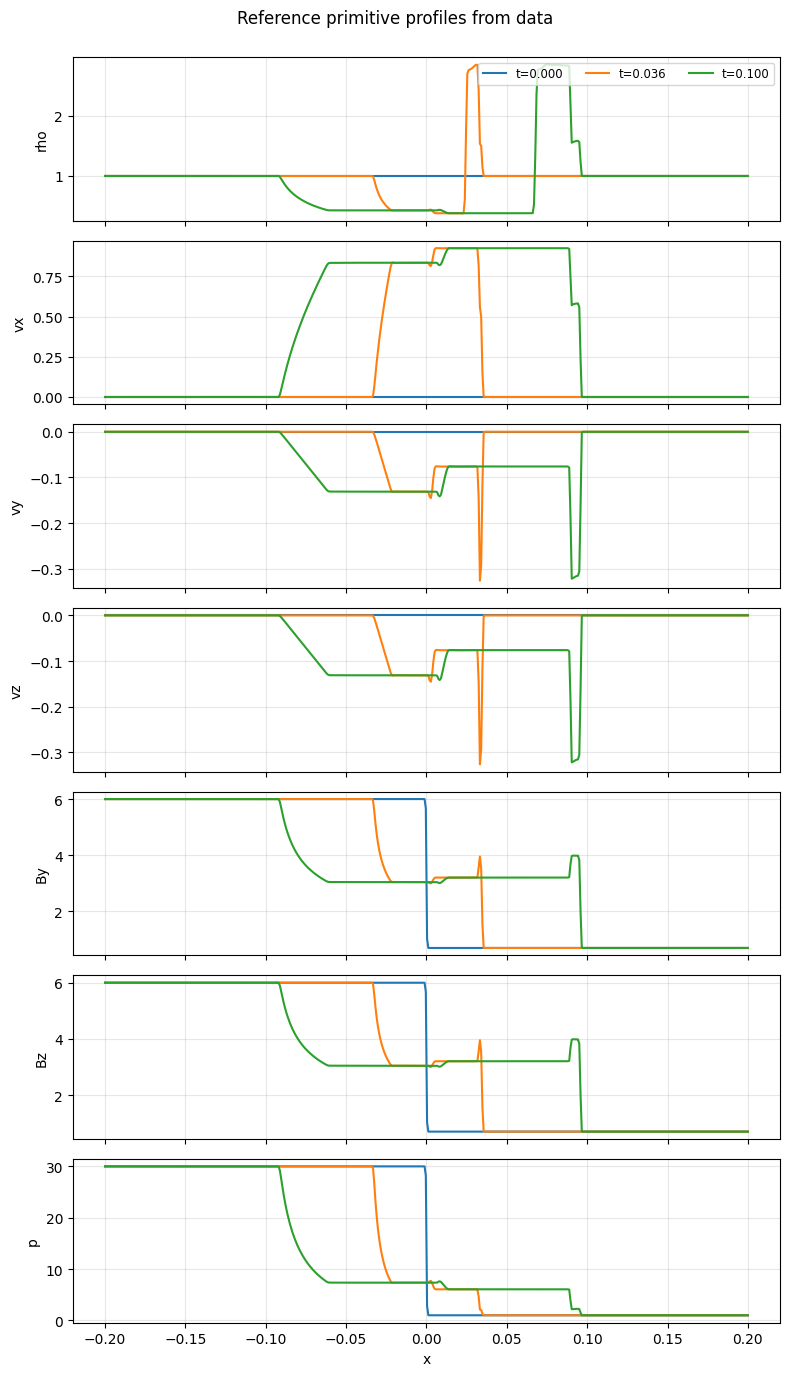

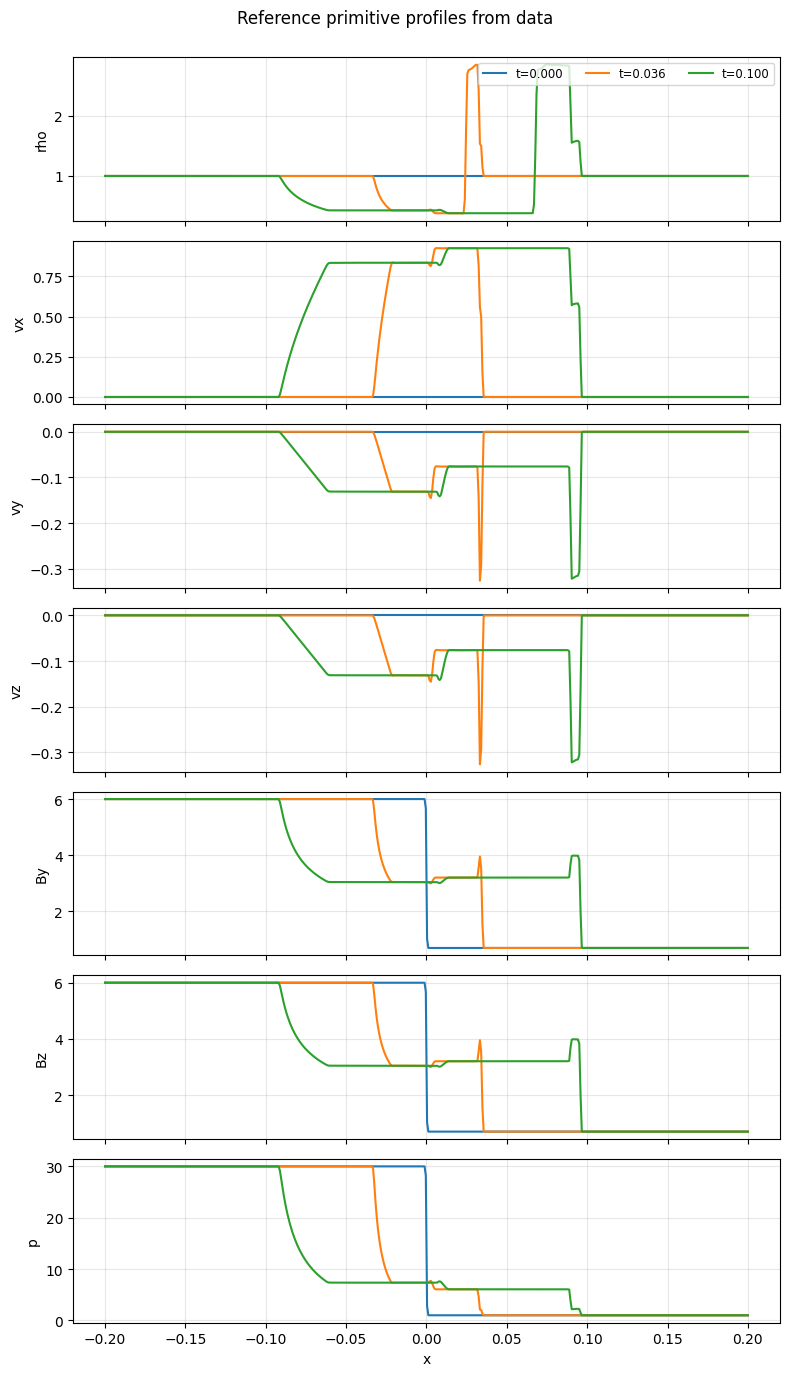

In [7]:
plot_reference_profiles(times=(0.0, 0.036, 0.1), num_points=512)

# RMHD residual helpers

In [8]:
#from RMHDEquations import conserved_alfredo, currents_alfredo
from RMHDEquations2D import primitives_to_conserved, flux_x

#GPT changed this helper. They are liable.
def _partial_derivative(outputs: torch.Tensor, coords: torch.Tensor, dim: int) -> torch.Tensor: 
    if outputs.ndim == 0:
        raise ValueError("outputs must have at least one dimension")

    outputs = outputs.reshape(-1, outputs.shape[-1])  # keeps (batch, components) no matter the input rank

    grads = []
    for component in range(outputs.shape[1]):
        grad = torch.autograd.grad(
            outputs[:, component].sum(),
            coords,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads.append(grad[:, dim])
    return torch.stack(grads, dim=1)


#def rmhd_residual2(primitives: torch.Tensor, coords: torch.Tensor) -> torch.Tensor:
 #   if not coords.requires_grad:
  #      raise ValueError("coords must require gradients for residual computation.")
   # conserved = conserved_alfredo(primitives)
   # currents = currents_alfredo(primitives)
   # dU_dt = _partial_derivative(conserved, coords, dim=1)
   # dJ_dx = _partial_derivative(currents, coords, dim=0)
   # return 0*dU_dt +  dJ_dx

def rmhd_residual(primitives: torch.Tensor, coords: torch.Tensor) -> torch.Tensor:
    if not coords.requires_grad:
        raise ValueError("coords must require gradients for residual computation.")
    
    B_x=5.0
    B_x_tensor = torch.full((primitives.shape[0], 1), B_x, device=primitives.device, dtype=primitives.dtype)
    primitives_2d = torch.cat([primitives[:, :4], B_x_tensor, primitives[:, 4:]], dim=1)
    mask1 = torch.tensor([0, 1, 2, 3, 5, 6, 7], device=primitives.device)
    conserved = primitives_to_conserved(primitives_2d,gamma=5/3)
    currents = flux_x(primitives_2d,gamma=5/3)
    conserved=conserved[:, mask1]
    currents=currents[:, mask1]
    dU_dt = _partial_derivative(conserved, coords, dim=1)
    dJ_dx = _partial_derivative(currents, coords, dim=0)
    return dU_dt +  dJ_dx



In [9]:
from jacobians import compute_M,compute_AX


def jacobian_residual(primitives: torch.Tensor, coords: torch.Tensor, B_x: float = 5.0) -> torch.Tensor:
    if not coords.requires_grad:
        raise ValueError("coords must require gradients for residual computation.")
    B_x=5.0
    B_x_tensor = torch.full((primitives.shape[0], 1), B_x, device=primitives.device, dtype=primitives.dtype)
    primitives_2d = torch.cat([primitives[:, :4], B_x_tensor, primitives[:, 4:]], dim=1)
    M = compute_M(primitives_2d)
    AX = compute_AX(primitives_2d)
    # Remove 4th row and 4th column (index 3) from M and AX
    mask1 = torch.tensor([0, 1, 2, 3, 5, 6, 7], device=M.device)
    #mask2 = torch.tensor([0, 1, 2, 4, 5, 6, 7], device=M.device)
    M = M[:, mask1, :][:, :, mask1]
    AX = AX[:, mask1, :][:, :, mask1]
    dP_dx = _partial_derivative(primitives, coords, dim=0).unsqueeze(-1)  # (batch, 7, 1)
    dP_dt = _partial_derivative(primitives, coords, dim=1).unsqueeze(-1)  # (batch, 7, 1)
    return (M @ dP_dt +  AX @ dP_dx).squeeze(-1)  # (batch, 7)



### testing

In [10]:
#coords_test = torch.tensor([[0.29, 0.13]], device=DEVICE, requires_grad=True)
#test1 = model(coords_test)  # shape (1, 7)

#jacobian_residual(test1, coords_test)

In [11]:
#rmhd_residual(test1, coords_test)

# Network 

In [12]:
class TrainableTanh(nn.Module):
    def __init__(self, init_gain=1.0, init_bias=0.0):
        super().__init__()
        self.log_gain = nn.Parameter(torch.tensor(float(np.log(init_gain))))
        self.bias = nn.Parameter(torch.tensor(init_bias))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gain = torch.exp(self.log_gain)  # keep gain positive
        return torch.tanh(gain * x + self.bias)

In [13]:
class PINN(nn.Module):
    def __init__(self, input_dim: int = 2, output_dim: int = 7, width: int = 16, depth: int = 12, activation=TrainableTanh):
        super().__init__()
        if depth < 1:
            raise ValueError("depth must be at least 1")
        self.activation = activation()
        layers = [nn.Linear(input_dim, width)]
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(width, output_dim)
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        x = coords
        for layer in self.layers:
            x = self.activation(layer(x))
        raw = self.output_layer(x)
        rho = torch.exp(raw[:, 0:1])
        velocities = torch.tanh(raw[:, 1:4])  # keep speeds subluminal
        by_bz = raw[:, 4:6]
        pressure = torch.exp(raw[:, 6:7])
        return torch.cat([rho, velocities, by_bz, pressure], dim=1)


# Training Loop

## samplers

In [14]:

from typing import Dict
from matplotlib.lines import Line2D

def sample_domain(n_points: int) -> torch.Tensor:
    x = torch.rand(n_points, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    t = torch.rand(n_points, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0]) + T_DOMAIN[0]
    coords = torch.cat([x, t], dim=1)
    coords.requires_grad_(True)
    return coords


def prepare_boundary_points(n_points: int) -> torch.Tensor:
    n_left = n_points // 2
    n_right = n_points - n_left
    x_left = torch.full((n_left, 1), X_DOMAIN[0], device=DEVICE)
    x_right = torch.full((n_right, 1), X_DOMAIN[1], device=DEVICE)
    return torch.cat([x_left, x_right], dim=0)


def log_history(history: Dict[str, list], key: str, value: torch.Tensor, window_size: int = 10):
    history.setdefault(key, []).append(value.detach().item())
    if len(history[key]) >= window_size:
        rolling_avg = np.mean(history[key][-window_size:])
        history[key][-1] = rolling_avg


def normalize_batch(preds: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Per-component RMS normalisation so all 7 primitives contribute on similar scale.

    Returns (preds_norm, targets_norm, inv_scale) where inv_scale is 1 / max(rms, eps).
    """
    diff = targets
    rms = torch.sqrt(torch.mean(diff.pow(2), dim=0, keepdim=True))
    inv_scale = 1.0 / torch.clamp(rms, min=eps)
    return preds * inv_scale, targets * inv_scale, inv_scale

#def normalize_intermediate_batch(u_samples, eps=1e-6):
#    """Return normalized targets along with mean/std used for scaling."""
#    with torch.no_grad():
#        mean = u_samples.mean(dim=0, keepdim=True)
#        std = u_samples.std(dim=0, keepdim=True, unbiased=False).clamp_min(eps)
#    normalized = (u_samples - mean) / std
#    return normalized, mean, std

#for time_float, t_samples, x_samples, u_samples in intermediate_batches:
#            normalized_targets, mean, std = normalize_intermediate_batch(u_samples)
#            intermediate_prediction = model_norm(t_samples, x_samples)
#            normalized_prediction = (intermediate_prediction - mean) / std
#            intermediate_loss = intermediate_criterion(normalized_prediction, normalized_targets)
#            total_intermediate_loss = total_intermediate_loss + intermediate_loss
#            intermediate_loss_histories_norm[time_float].append(intermediate_loss.item())
    




In [15]:
def sample_domain_residual_guided(
    model: PINN,
    n_points: int,
    oversample_factor: int = 4,
    min_prob: float = 1e-12,
    residual_power: float = 1.0,
) -> torch.Tensor:
    """
    Draw n_points (x, t) locations with probability ∝ residual^residual_power.
    residual_power < 1.0 flattens the distribution; > 1.0 emphasizes large errors.
    """
    model_was_training = model.training
    model.eval()

    n_candidates = oversample_factor * n_points
    coords_candidates = sample_domain(n_candidates)  # already requires_grad_(True)

    with torch.enable_grad():
        preds = model(coords_candidates)
        residual = jacobian_residual(preds, coords_candidates)
        weights = residual.norm(dim=1).detach()

    if residual_power != 1.0:
        weights = torch.pow(weights, residual_power)

    probs = weights + min_prob
    total = probs.sum()
    if not torch.isfinite(total) or total <= 0:
        idx = torch.randperm(n_candidates, device=coords_candidates.device)[:n_points]
    else:
        probs = probs / total
        idx = torch.multinomial(probs, n_points, replacement=False)

    selected = coords_candidates[idx].detach().requires_grad_(True)
    if model_was_training:
        model.train()
    return selected

In [16]:
def sample_domain_residual_guided2(
    model: PINN,
    n_points: int,
    oversample_factor: int = 4,
    min_prob: float = 1e-12,
    residual_power: float = 1.0,
) -> torch.Tensor:
    """
    Draw n_points (x, t) locations with probability ∝ residual^residual_power.
    residual_power < 1.0 flattens the distribution; > 1.0 emphasizes large errors.
    """
    model_was_training = model.training
    model.eval()

    n_candidates = oversample_factor * n_points
    coords_candidates = sample_domain(n_candidates)  # already requires_grad_(True)

    with torch.enable_grad():
        preds = model(coords_candidates)
        residual = jacobian_residual(preds, coords_candidates)
        weights = residual.norm(dim=1).detach()

    if residual_power != 1.0:
        weights = torch.pow(weights, residual_power)

    probs = weights + min_prob
    total = probs.sum()
    if not torch.isfinite(total) or total <= 0:
        idx = torch.randperm(n_candidates, device=coords_candidates.device)[:n_points]
    else:
        probs = probs / total
        idx = torch.multinomial(probs, n_points, replacement=False)

    residual_selected = residual[idx]

    if model_was_training:
        model.train()
    return residual_selected

## plotter

In [17]:
PLOT_LABELS= ['By']

In [18]:
def plot_training_progress(history: Dict[str, list], model: PINN, epoch: int, epochs: int):
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

    ax_loss = fig.add_subplot(gs[0, 0])
    for name, series in history.items():
        if not series:
            continue
        steps = np.arange(1, len(series) + 1)
        values = np.clip(np.asarray(series, dtype=np.float64), 1e-16, None)
        ax_loss.plot(steps, values, label=name)
    ax_loss.set_yscale('log')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss value')
    ax_loss.legend(fontsize='small', ncol=2)
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_title('Loss history')

    ax_heat = fig.add_subplot(gs[0, 1])
    x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 128, device=DEVICE)
    t_vis = torch.linspace(T_DOMAIN[0], T_DOMAIN[1], 128, device=DEVICE)
    X_mesh, T_mesh = torch.meshgrid(x_vis, t_vis, indexing='ij')
    coords_vis = torch.stack([X_mesh.reshape(-1), T_mesh.reshape(-1)], dim=1)
    with torch.no_grad():
        rho_vis = model(coords_vis).detach().cpu().numpy()[:, 0]
    rho_vis = rho_vis.reshape(x_vis.shape[0], t_vis.shape[0])
    pcm = ax_heat.pcolormesh(T_mesh.cpu().numpy(), X_mesh.cpu().numpy(), rho_vis, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax_heat, label='rho')
    ax_heat.set_xlabel('t')
    ax_heat.set_ylabel('x')
    ax_heat.set_title('Density heatmap')







    ax_compare = fig.add_subplot(gs[1, :])
    x_plot = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 256, device=DEVICE)
    coords_plot = torch.stack([x_plot, torch.full_like(x_plot, 0.036)], dim=1)
    with torch.no_grad():
        pinn_profiles = model(coords_plot).detach().cpu().numpy()
    reference_profiles = cond(0.036, x_plot.cpu().numpy(), as_tensor=False)

    entries = PLOT_LABELS or PRIMITIVE_LABELS
    resolved = []
    for entry in entries:
        if isinstance(entry, int):
            resolved.append((entry, PRIMITIVE_LABELS[entry]))
        else:
            idx = next(i for i, name in enumerate(PRIMITIVE_LABELS) if name.lower() == str(entry).lower())
            resolved.append((idx, PRIMITIVE_LABELS[idx]))

    x_np = x_plot.cpu().numpy()
    colors = plt.cm.tab10(np.linspace(0, 1, len(resolved)))
    for color, (idx, label) in zip(colors, resolved):
        ax_compare.plot(x_np, pinn_profiles[:, idx], color=color, linestyle='-', linewidth=1.2)
        ax_compare.plot(x_np, reference_profiles[:, idx], color=color, linestyle='--', linewidth=1.0)

    handles = [Line2D([0], [0], color=color) for color in colors]
    ax_compare.legend(handles, [label for _, label in resolved], title='Primitive', loc='upper right', fontsize='small')
    ax_compare.legend(handles=[
        Line2D([0], [0], color='black', linestyle='-', label='PINN'),
        Line2D([0], [0], color='black', linestyle='--', label='Data'),
    ], loc='lower right', fontsize='small')
    ax_compare.set_xlabel('x')
    ax_compare.set_title('t = 0.036 comparison')
    ax_compare.grid(True, alpha=0.3)






    fig.suptitle(f'Epoch {epoch}/{epochs}')
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    display(fig)
    plt.close(fig)


# Instantiate the NN and optimizer


In [19]:
model = PINN(width=64, depth=24).to(DEVICE)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Placeholder for future Gauss-Newton helper integration


gauss_newton_optimizer = GaussNewtonPINNOptimizer(
    model,
    damping=1e-1,
    damping_increase=4.0,
    damping_decrease=0.25,
    reg_weight=1e-6,
    vectorize_jacobian=True,
    use_direct_solve=False,
    cg_max_iters=400,
    cg_tol=1e-9,
    report_linear_solvers=False,
)


import torch.distributed as dist

if dist.is_available() and not dist.is_initialized():
    dist.init_process_group(
        backend="gloo",
        init_method="file:///tmp/muon_pg",
        rank=0,
        world_size=1,
    )


optimizer = PINNMuonOptimizer(
    model,
    lr_muon=1e-3,
    weight_decay_muon=1e-4,
    lr_other=1e-3,
    weight_decay_other=0.0,
)
     

[W1105 00:16:59.160953000 ProcessGroupGloo.cpp:547] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())


In [20]:
print(model(torch.tensor([[0.0, 0.0]], device=DEVICE)))  # test forward pass

print(model(torch.tensor([[0.0, 0.0]], device=DEVICE)).detach().cpu().numpy()[:,1])

tensor([[1., 0., 0., 0., 0., 0., 1.]], device='mps:0', grad_fn=<CatBackward0>)
[0.]


In [21]:
condition_times = [0.0, 0.036, 0.1]

loss_history = {"domain": [], "boundary": [], "total": []}
for t in condition_times:
    loss_history[f"t={t:.3f}"] = []

# Adam training loop

In [22]:
lambda_domain_schedule = [0.07, 0.1, 0.13, 0.2, 0.6] # [0.0001, 0.0001, 0.0005]  #[1.6, 1.8, 2.0, 2.0] # [0.001, 0.01, 0.06, 0.1]
#lambda_domain_schedule = [0.6, 0.7, 0.7, 1.0, 1.0, 1.5]

lambda_domain_schedule[0]

0.07

KeyboardInterrupt: 

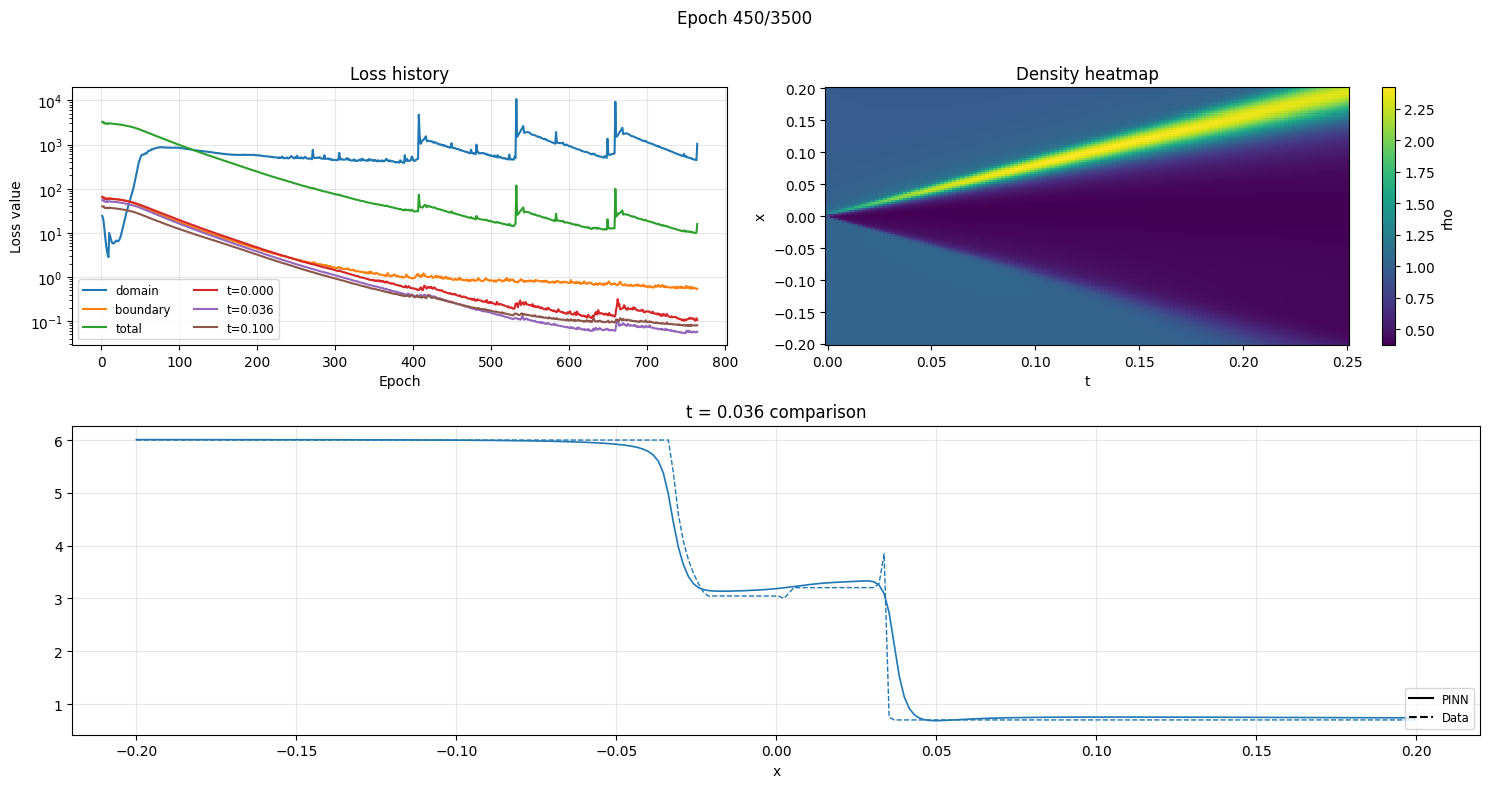

In [ ]:
epochs = 3500
n_domain = 1024
n_intermediate = 2048
n_boundary = 256
lambda_domain =  0.01 #0.0001 #0.1 #0.06 #0.01 #0.005 #0.001 #0.0. //// #0.04 #0.01 #0.0
lambda_bdy = 1.0
lambda_time = {0.0: 20.0, 0.036: 20.0, 0.1: 20.0} #{0.0: 20.0, 0.036: 20.0, 0.1: 20.0}

schedule = 1000


for epoch in range(1, epochs + 1):

    if epoch % schedule == 0 and epoch // schedule - 1 < len(lambda_domain_schedule):
        lambda_domain = lambda_domain_schedule[epoch // schedule - 1]

    model.train()
    #optimizer.zero_grad(set_to_none=True) #ADAM
    optimizer.zero_grad()

    coords_domain = sample_domain(n_domain)
    preds_domain = model(coords_domain)
    residual = jacobian_residual(preds_domain, coords_domain)
    
    #coords_domain = sample_domain_residual_guided(model, n_domain, oversample_factor=4, residual_power=4.0) 
    #preds_domain = model(coords_domain)
    #residual = jacobian_residual(preds_domain, coords_domain)

    #residual = sample_domain_residual_guided2(model, n_domain, oversample_factor=4, residual_power=4.0)

    domain_loss = F.mse_loss(residual, torch.zeros_like(residual))
    total_loss = lambda_domain * domain_loss

   # residual_test = rmhd_residual(preds_domain, coords_domain)
   # test_loss = F.mse_loss(residual_test, torch.zeros_like(residual_test))+1000.0 # added a offset to compare in plot.

#intermediate loss
    x_data = torch.rand(n_intermediate, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    data_losses = {}
    for t in condition_times:
        t_tensor = torch.full_like(x_data, fill_value=t)
        coords_data = torch.cat([x_data, t_tensor], dim=1)
        preds_data = model(coords_data)
        targets_data = cond(t, x_data.squeeze(-1), device=DEVICE)
        #preds_norm, targets_norm, inv_scale = normalize_batch(preds_data, targets_data)
        data_loss = F.mse_loss(preds_data, targets_data)
        #data_loss = F.mse_loss(preds_norm, targets_norm)
        data_losses[f"t={t:.3f}"] = data_loss
        total_loss = total_loss + lambda_time[t] * data_loss


#boundary loss
#    x_boundary = prepare_boundary_points(n_boundary)
#    boundary_terms = []
#    for t in condition_times:
#        t_boundary = torch.full((x_boundary.shape[0], 1), t, device=DEVICE)
#        coords_boundary = torch.cat([x_boundary, t_boundary], dim=1)
#        preds_boundary = model(coords_boundary)
#        targets_boundary = cond(t, x_boundary.squeeze(-1), device=DEVICE)
#        #preds_norm, targets_norm, inv_scale = normalize_batch(preds_boundary, targets_boundary)
    
    
    
    
#    boundary_terms.append(F.mse_loss(preds_boundary, targets_boundary))
#    boundary_loss = torch.stack(boundary_terms).mean()
    x_boundary = prepare_boundary_points(n_boundary)            # (n_boundary, 1)
    #half = n_boundary // 2

    t_half = torch.rand(n_boundary // 2, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0] - 0.02) + T_DOMAIN[0] #offset to avoid final time if the wave reaches
    t_boundary = torch.cat([t_half, t_half], dim=0)

    #if t_boundary.size(0) < n_boundary:  # safeguard for odd n_boundary
     #   extra = torch.rand(1, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0]) + T_DOMAIN[0]
      #  t_boundary = torch.cat([t_boundary, extra], dim=0)

    coords_boundary = torch.cat([x_boundary, t_boundary], dim=1)

    preds_boundary = model(coords_boundary)
    targets_boundary = cond(0.0, x_boundary.squeeze(-1), device=DEVICE)  # open-boundary target
    boundary_loss = F.mse_loss(preds_boundary, targets_boundary)
    total_loss = total_loss + lambda_bdy * boundary_loss


#optimizer step
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.6)
    optimizer.step()

   # log_history(loss_history, "test_domain", test_loss)
    log_history(loss_history, "domain", domain_loss)
    for key, loss_value in data_losses.items():
        log_history(loss_history, key, loss_value)
    log_history(loss_history, "boundary", boundary_loss)
    log_history(loss_history, "total", total_loss)

    if epoch % 50 == 0 or epoch == 1:
        clear_output(wait=True)
        plot_training_progress(loss_history, model, epoch, epochs)
        latest_losses = {
            "domain": loss_history["domain"][-1],
            "boundary": loss_history["boundary"][-1],
            **{k: loss_history[k][-1] for k in data_losses},
            "total": loss_history["total"][-1],
        }
        print(
            "Epoch "
            f"{epoch}/{epochs} - "
            + ", ".join(f"{name}: {value:.3e}" for name, value in latest_losses.items())
        )


# Residual Network

In [25]:
model.eval();

In [26]:
def build_residual_mixture_coords(
    model: PINN,
    grid_size: int,
    *,
    candidate_factor: int = 3,
    residual_power: float = 3.0,
    uniform_mix: float = 0.1,
    eps: float = 1e-12,
) -> torch.Tensor:
    """
    Return grid_size**2 coordinates drawn from a residual-weighted + uniform mixture.

    - candidate_factor controls how many candidates we evaluate before sampling.
    - residual_power sharpens (>1) or flattens (<1) the residual weighting.
    - uniform_mix (0..1) is the fraction of probability mass kept uniform so that
      low-residual regions still appear in the grid.
    """

    n_keep = grid_size * grid_size
    n_candidates = candidate_factor * n_keep
    coords_candidates = sample_domain(n_candidates)

    with torch.enable_grad():
        preds = model(coords_candidates)
        residual = jacobian_residual(preds, coords_candidates)
        weights = residual.norm(dim=1).detach()

    if residual_power != 1.0:
        weights = weights.pow(residual_power)

    weights = weights.clamp(min=0)
    weighted = weights / (weights.sum() + eps)
    uniform = torch.full_like(weighted, 1.0 / n_candidates)

    probs = (1.0 - uniform_mix) * weighted + uniform_mix * uniform
    probs = probs / probs.sum()  # numerical guard

    idx = torch.multinomial(probs, n_keep, replacement=False)
    coords_residual = coords_candidates[idx].detach()


    return coords_residual

In [27]:
coords_residual = build_residual_mixture_coords(
    model,
    grid_size=128,          # final grid dimension
    candidate_factor=4,     # evaluate 8× as many points before sampling
    residual_power=3.0,     # bias toward larger residuals
    uniform_mix=0.1,        # keep 10% uniform mass so small residuals stay represented
)

In [28]:
#n_res = 200

def sample_res(n_res: int) -> torch.Tensor:
    indices = torch.randperm(coords_residual.shape[0])[:n_res]
    sample = coords_residual[indices]
    return indices, sample.requires_grad_(True)


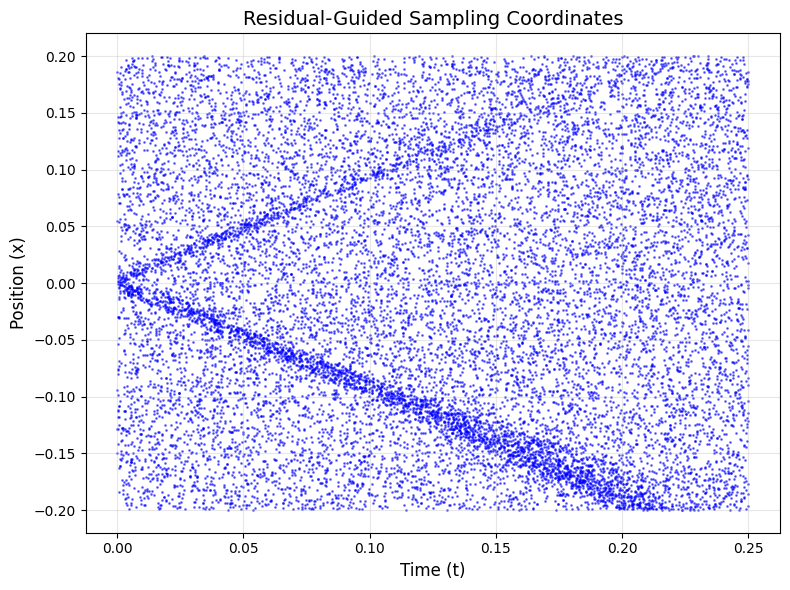

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

# Extract x and t coordinates
x_coords = coords_residual[:, 0].cpu().numpy()
t_coords = coords_residual[:, 1].cpu().numpy()

# Create scatter plot
scatter = ax.scatter(t_coords, x_coords, c='blue', alpha=0.5, s=1)

ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Position (x)', fontsize=12)
ax.set_title('Residual-Guided Sampling Coordinates', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [30]:
#n_res_gr = 512

#residual_x = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], n_res_gr, device=DEVICE)
#residual_t= torch.linspace(T_DOMAIN[0], T_DOMAIN[1], n_res_gr, device=DEVICE)
#residual_grid= torch.meshgrid(residual_x, residual_t, indexing='ij')
#coords_residual= torch.stack([residual_grid[0].reshape(-1), residual_grid[1].reshape(-1)], dim=1)



## Data saving

In [31]:
def data_out(primitives: torch.Tensor, coords: torch.Tensor, B_x: float = 5.0) -> torch.Tensor:
    if not coords.requires_grad:
        raise ValueError("coords must require gradients for residual computation.")
    B_x=5.0
    B_x_tensor = torch.full((primitives.shape[0], 1), B_x, device=primitives.device, dtype=primitives.dtype)
    primitives_2d = torch.cat([primitives[:, :4], B_x_tensor, primitives[:, 4:]], dim=1)
    M = compute_M(primitives_2d)
    AX = compute_AX(primitives_2d)
    # Remove 4th row and 4th column (index 3) from M and AX
    mask1 = torch.tensor([0, 1, 2, 3, 5, 6, 7], device=M.device)
    #mask2 = torch.tensor([0, 1, 2, 4, 5, 6, 7], device=M.device)
    M = M[:, mask1, :][:, :, mask1]
    AX = AX[:, mask1, :][:, :, mask1]
    dP_dx = _partial_derivative(primitives, coords, dim=0).unsqueeze(-1)  # (batch, 7, 1)
    dP_dt = _partial_derivative(primitives, coords, dim=1).unsqueeze(-1)  # (batch, 7, 1)
    return M, AX, dP_dt , dP_dx

In [32]:
batch_size = coords_residual.shape[0]
chunk_size = 4096 #8192          # adjust for your GPU/MPS
chunks = []
start = 0

M_list, AX_list, S_list, dpdt_list, dpdx_list = [], [], [], [], []

while start < batch_size:
    end = min(start + chunk_size, batch_size)

    coords_chunk = coords_residual[start:end].detach().requires_grad_(True)
    prim_chunk = model(coords_chunk)

    M_chunk, AX_chunk, dpdt_chunk, dpdx_chunk = data_out(prim_chunk, coords_chunk, B_x=5.0)

    M_flat  = M_chunk.reshape(M_chunk.size(0), -1)
    AX_flat = AX_chunk.reshape(AX_chunk.size(0), -1)

    dM_dt  = _partial_derivative(M_flat,  coords_chunk, dim=1).reshape_as(M_chunk)
    dAX_dx = _partial_derivative(AX_flat, coords_chunk, dim=0).reshape_as(AX_chunk)

    S_chunk = dM_dt + dAX_dx

    M_list.append(M_chunk.detach())
    AX_list.append(AX_chunk.detach())
    S_list.append(S_chunk.detach())
    dpdt_list.append(dpdt_chunk.detach())
    dpdx_list.append(dpdx_chunk.detach())

    del coords_chunk, prim_chunk, M_chunk, AX_chunk, dM_dt, dAX_dx, S_chunk, dpdt_chunk, dpdx_chunk
    torch.mps.empty_cache()   # or torch.cuda.empty_cache()

    start = end

M_r  = torch.cat(M_list,  dim=0)
AX_r = torch.cat(AX_list, dim=0)
S_r  = torch.cat(S_list,  dim=0)
dpdt_r = torch.cat(dpdt_list, dim=0)
dpdx_r = torch.cat(dpdx_list, dim=0)

In [54]:
def lin_eq(output: torch.Tensor, ind: int, coords: torch.Tensor) -> torch.Tensor:
    
    dp_dt = _partial_derivative(output, coords, dim=1).unsqueeze(-1)  # (batch, 7, 1)
    dp_dx = _partial_derivative(output, coords, dim=0).unsqueeze(-1)  # (batch, 7, 1)
    p = output.unsqueeze(-1)  # (batch, 7, 1)

    return (M_r[ind] @ (dp_dt - dpdt_r[ind]) + AX_r[ind] @ (dp_dx - dpdx_r[ind]) + S_r[ind] @ p).squeeze(-1)  # (batch, 7)

## New architecture？

In [34]:
from typing import Sequence

class FFPINN(nn.Module):
    def __init__(
        self,
        input_dim: int = 2,
        output_dim: int = 7,
        width: int = 32,
        depth: int = 6,
        activation=TrainableTanh,
        fourier_features: int = 32,
        m: int = 3,
        sigmas: Sequence[float] | float = 3.0, #sigma: float = 3.0,
    ):
        super().__init__()
        if depth < 1:
            raise ValueError("depth must be at least 1")
        if m < 1:
            raise ValueError("m (number of Fourier blocks) must be at least 1")

        self.activation = activation()
        self.width = width
        self.depth = depth
        self.m = m
        self.fourier_features = fourier_features

        if isinstance(sigmas, (float, int)):
            sigmas = [float(sigmas)] * m
        elif len(sigmas) != m:
            raise ValueError(f"sigmas length ({len(sigmas)}) must equal m ({m})")
        self.register_buffer("sigmas", torch.tensor(sigmas, dtype=torch.float32))

        #self.sigma = sigma

        # Non-trainable Fourier projection matrices B^(i)
        self.register_buffer("B", torch.empty(m, fourier_features, input_dim))
        self.resample_fourier_matrix()

        layers = [nn.Linear(2 * fourier_features, width)]
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
        self.layers = nn.ModuleList(layers)

        self.output_layer = nn.Linear(width * m, output_dim)
        self.reset_parameters()

    def resample_fourier_matrix(self) -> None:
        #with torch.no_grad():
        #    self.B.normal_(mean=0.0, std=self.sigma)
        with torch.no_grad():
            for i in range(self.m):
                self.B[i].normal_(mean=0.0, std=self.sigmas[i])



    def reset_parameters(self) -> None:
        self.resample_fourier_matrix()
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        hidden_blocks = []
        for i in range(self.m):
            projections = coords @ self.B[i].T
            gamma = torch.cat(
                [torch.cos(2 * math.pi * projections), torch.sin(2 * math.pi * projections)],
                dim=-1,
            )
            h = gamma
            for layer in self.layers:
                h = self.activation(layer(h))
            hidden_blocks.append(h)

        stacked = torch.cat(hidden_blocks, dim=-1)
        raw = self.output_layer(stacked)

        rho = torch.exp(raw[:, 0:1])
        velocities = torch.tanh(raw[:, 1:4])  # enforce subluminal speeds
        by_bz = raw[:, 4:6]
        pressure = torch.exp(raw[:, 6:7])
        return torch.cat([rho, velocities, by_bz, pressure], dim=1)

## Instantiate Residual Network

In [75]:
model_residual = PINN(width=36, depth=16).to(DEVICE) #PINN(width=24, depth=12).to(DEVICE)
#model_residual = FFPINN(width=32, depth=8, fourier_features=32, m=4, sigmas=[10.0, 50.0, 1.0, 0.5]).to(DEVICE)


#optimizer = torch.optim.Adam(model_residual.parameters(), lr=0.01)#lr=0.0001)
# Placeholder for future Gauss-Newton helper integration

optimizer = PINNMuonOptimizer(
    model_residual,
    lr_muon=1e-3,
    weight_decay_muon=1e-4,
    lr_other=1e-3,
    weight_decay_other=0.0,
)

loss_history_residual = {"domain": [], "boundary": [], "total": []}
for t in condition_times:
    loss_history_residual[f"t={t:.3f}"] = []


res_loss_history = []
domain_loss_history = []
window_size = 10



In [76]:
model_residual(torch.tensor([[0.2, 0.13]], device=DEVICE))  # test forward pass

tensor([[ 0.9923, -0.0113, -0.0051,  0.0610, -0.0047, -0.0282,  1.0403]],
       device='mps:0', grad_fn=<CatBackward0>)

## Training Residual NET

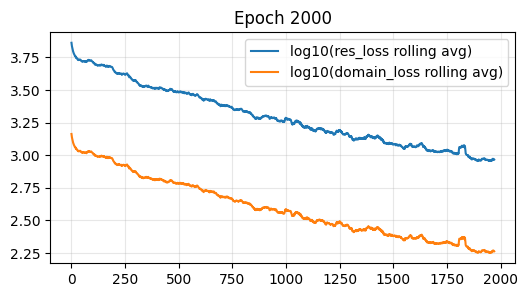

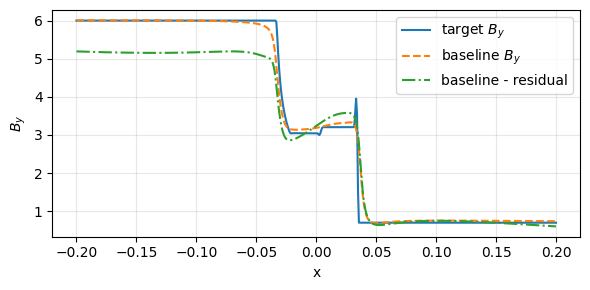

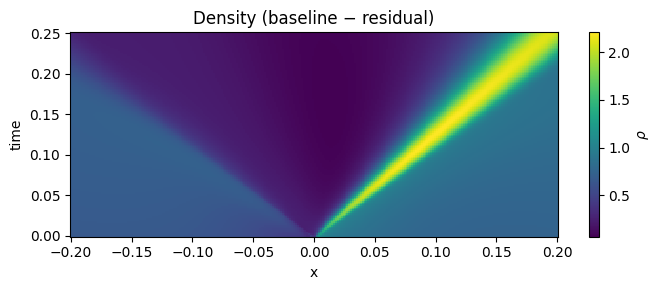

In [77]:
epochs = 2000
n_res = 4096
n_intermediate = 2048
n_boundary = 1024
lambda_domain =  5.0 #0.06 #0.01 #0.005 #0.001 #0.0. //// #0.04 #0.01 #0.0
lambda_bdy = 1.0
lambda_time = {0.0: 10.0, 0.036: 10.0, 0.1: 10.0} #{0.0: 20.0, 0.036: 20.0, 0.1: 20.0}
window_size = 30

for epoch in range(1, epochs + 1):
    model_residual.train()
    #optimizer.zero_grad(set_to_none=True)
    optimizer.zero_grad()

    idx_res, coords_domain = sample_res(n_res)
    preds_domain = model_residual(coords_domain)
    residual = lin_eq(preds_domain, idx_res, coords_domain)
   # print( residual.shape)
    domain_loss = F.mse_loss(residual, torch.zeros_like(residual))
    res_loss = lambda_domain * domain_loss
    #print(res_loss)

   # residual_test = rmhd_residual(preds_domain, coords_domain)
   # test_loss = F.mse_loss(residual_test, torch.zeros_like(residual_test))+1000.0 # added a offset to compare in plot.

#intermediate loss
    x_data = torch.rand(n_intermediate, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    data_losses = {}
    for t in condition_times:
        t_tensor = torch.full_like(x_data, fill_value=t)
        coords_data = torch.cat([x_data, t_tensor], dim=1)
        preds_data = model_residual(coords_data)
        targets_data = -cond(t, x_data.squeeze(-1), device=DEVICE) + model(coords_data).detach()
        data_loss = F.mse_loss(preds_data, targets_data)
        data_losses[f"t={t:.3f}"] = data_loss
        res_loss = res_loss + lambda_time[t] * data_loss


#boundary loss
    x_boundary = prepare_boundary_points(n_boundary)  # first half left, second half right


    t_half = torch.rand(n_boundary // 2, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0]- 0.02) + T_DOMAIN[0] #
    t_boundary = torch.cat([t_half, t_half], dim=0)
    
    coords_boundary = torch.cat([x_boundary, t_boundary], dim=1)

    preds_boundary = model_residual(coords_boundary)
    targets_boundary = -cond(0.0, x_boundary.squeeze(-1), device=DEVICE) +  model(coords_boundary).detach()  # open BC at t = 0

    boundary_loss = F.mse_loss(preds_boundary, targets_boundary)
    res_loss = res_loss + lambda_bdy * boundary_loss


#optimizer step
    res_loss.backward()
    torch.nn.utils.clip_grad_norm_(model_residual.parameters(), max_norm=0.1)
    optimizer.step()





    res_loss_value    = res_loss.item()
    domain_loss_value = domain_loss.item()

    res_loss_history.append(res_loss_value)
    domain_loss_history.append(domain_loss_value)
    
    # Compute rolling averages
    

    #print(f"Epoch {epoch:4d} | res_loss = {res_loss_value:.4e} | domain_loss = {domain_loss_value:.4e}")
    
    # --- loss history (log scale) ---
    if epoch % 50 == 0 or epoch == 1:
        clear_output(wait=True)
        if len(res_loss_history) >= window_size:
            res_loss_rolling = np.convolve(res_loss_history, np.ones(window_size)/window_size, mode='valid')
            domain_loss_rolling = np.convolve(domain_loss_history, np.ones(window_size)/window_size, mode='valid')
        else:
            res_loss_rolling = res_loss_history
            domain_loss_rolling = domain_loss_history
        
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(np.log10(res_loss_rolling), label='log10(res_loss rolling avg)')
        ax.plot(np.log10(domain_loss_rolling), label='log10(domain_loss rolling avg)')
        ax.set_title(f'Epoch {epoch}')
        ax.grid(alpha=0.3)
        ax.legend()
        
        # --- B_y cross-section at t = 0.036 ---
        t_vis = 0.036
        x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 512, device=DEVICE).unsqueeze(-1)
        coords_vis = torch.cat([x_vis, torch.full_like(x_vis, t_vis)], dim=1)
        with torch.no_grad():
            baseline = model(coords_vis)
            residual = model_residual(coords_vis)
            corrected = baseline - residual
            target = cond(t_vis, x_vis.squeeze(-1), device=DEVICE)

        x_cpu = x_vis.squeeze(-1).cpu().numpy()
        
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(x_cpu, target[:, 4].cpu(), label='target $B_y$')
        ax.plot(x_cpu, baseline[:, 4].cpu(), '--', label='baseline $B_y$')
        ax.plot(x_cpu, corrected[:, 4].cpu(), '-.', label='baseline - residual')
        ax.set_xlabel('x')
        ax.set_ylabel('$B_y$')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # --- density heatmap of baseline - residual ---
        times = torch.linspace(0.0, 0.25, 120, device=DEVICE)
        x_heat = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 256, device=DEVICE)
        rho_map = torch.empty(times.size(0), x_heat.size(0), device=DEVICE)
        with torch.no_grad():
            for i, t in enumerate(times):
                coords = torch.stack((x_heat, torch.full_like(x_heat, t)), dim=1)
                rho_map[i] = (model(coords) - model_residual(coords))[:, 0]
        
        fig, ax = plt.subplots(figsize=(7, 3))
        pcm = ax.pcolormesh(x_heat.cpu(), times.cpu(), rho_map.cpu(), shading='auto', cmap='viridis')
        fig.colorbar(pcm, ax=ax, label=r'$\rho$')
        ax.set_xlabel('x')
        ax.set_ylabel('time')
        ax.set_title('Density (baseline − residual)')
        plt.tight_layout()
        plt.show()


## Other instantiations...

In [84]:
model_residual2 = PINN(width=48, depth=64).to(DEVICE) #PINN(width=24, depth=12).to(DEVICE)
#model_residual2 = FFPINN(width=24, depth=12, fourier_features=32, m=4, sigmas=[10.0, 100.0, 1.0,5.0]).to(DEVICE)

#optimizer = torch.optim.Adam(model_residual2.parameters(), lr=0.001)#lr=0.0001)
#optimizer = torch.optim.LBFGS(model_residual2.parameters(), lr=0.1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=10, line_search_fn='strong_wolfe')
# Placeholder for future Gauss-Newton helper integration

optimizer = PINNMuonOptimizer(
    model_residual2,
    lr_muon=1e-3,
    weight_decay_muon=1e-4,
    lr_other=1e-3,
    weight_decay_other=0.0,
)

loss_history_residual = {"domain": [], "boundary": [], "total": []}
for t in condition_times:
    loss_history_residual[f"t={t:.3f}"] = []


res_loss_history = []
domain_loss_history = []
data_loss_history = []
boundary_loss_history = []
    
window_size = 10


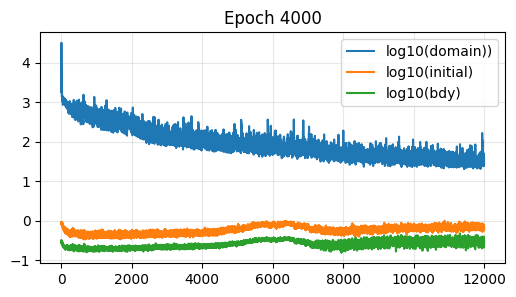

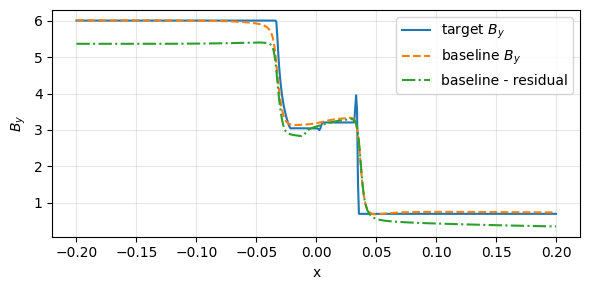

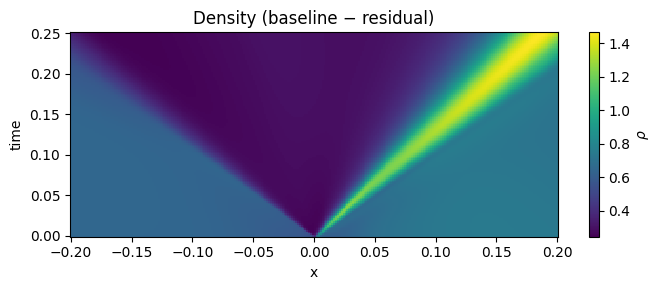

In [94]:
epochs = 4000
n_res = 4096
n_intermediate = 1024
n_boundary = 1024
lambda_domain = 5.0 #0.001 # 1.0 #/// #0.06 #0.01 #0.005 #0.001 #0.0. //// #0.04 #0.01 #0.0
lambda_bdy = 1.0
condition_times = [0.0, 0.036, 0.1]#, 0.036, 0.1]
lambda_time = {0.0: 1.0 , 0.036: 0.01, 0.1: 0.01} #{0.0: 20.0, 0.036: 20.0, 0.1: 20.0}
window_size = 30

for epoch in range(1, epochs + 1):
    model_residual2.train()
    #optimizer.zero_grad(set_to_none=True)
    optimizer.zero_grad()

    idx_res, coords_domain = sample_res(n_res)
    preds_domain = model_residual2(coords_domain)
    residual = lin_eq(preds_domain, idx_res, coords_domain)
   # print( residual.shape)
    domain_loss = F.mse_loss(residual, torch.zeros_like(residual))
    res_loss = lambda_domain * domain_loss
    #print(res_loss)

   # residual_test = rmhd_residual(preds_domain, coords_domain)
   # test_loss = F.mse_loss(residual_test, torch.zeros_like(residual_test))+1000.0 # added a offset to compare in plot.

#intermediate loss
    x_data = torch.rand(n_intermediate, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    data_losses = {}
    for t in condition_times:
        t_tensor = torch.full_like(x_data, fill_value=t)
        coords_data = torch.cat([x_data, t_tensor], dim=1)
        preds_data = model_residual2(coords_data)
        targets_data = -cond(t, x_data.squeeze(-1), device=DEVICE) + model(coords_data).detach()
        data_loss = F.mse_loss(preds_data, targets_data)
        data_losses[f"t={t:.3f}"] = data_loss
        res_loss = res_loss + lambda_time[t] * data_loss


#boundary loss
    x_boundary = prepare_boundary_points(n_boundary)  # first half left, second half right


    t_half = torch.rand(n_boundary // 2, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0]-0.02) + T_DOMAIN[0] #to avoid t=0.25
    t_boundary = torch.cat([t_half, t_half], dim=0)
    
    coords_boundary = torch.cat([x_boundary, t_boundary], dim=1)

    preds_boundary = model_residual2(coords_boundary)
    targets_boundary = -cond(0.0, x_boundary.squeeze(-1), device=DEVICE) +  model(coords_boundary).detach()  # open BC at t = 0

    boundary_loss = F.mse_loss(preds_boundary, targets_boundary)
    res_loss = res_loss + lambda_bdy * boundary_loss


#optimizer step
    res_loss.backward()
   # torch.nn.utils.clip_grad_norm_(model_residual2.parameters(), max_norm=0.8)
    optimizer.step()





    res_loss_value    = res_loss.item()
    domain_loss_value = domain_loss.item()
    boundary_loss_value = boundary_loss.item()
    data_loss_value = sum(data_losses.values()).item()

    res_loss_history.append(res_loss_value)
    domain_loss_history.append(domain_loss_value)
    data_loss_history.append(data_loss_value)
    boundary_loss_history.append(boundary_loss_value)
    
    # Compute rolling averages
    

    #print(f"Epoch {epoch:4d} | res_loss = {res_loss_value:.4e} | domain_loss = {domain_loss_value:.4e}")
    
    # --- loss history (log scale) ---
    if epoch % 50 == 0 or epoch == 1:
        clear_output(wait=True)
        if len(res_loss_history) >= window_size:
            res_loss_rolling = np.convolve(res_loss_history, np.ones(window_size)/window_size, mode='valid')
            domain_loss_rolling = np.convolve(domain_loss_history, np.ones(window_size)/window_size, mode='valid')
        else:
            res_loss_rolling = res_loss_history
            domain_loss_rolling = domain_loss_history
        
        fig, ax = plt.subplots(figsize=(6, 3))
      #  ax.plot(np.log10(res_loss_rolling), label='log10(res_loss rolling avg)')
        #ax.plot(np.log10(domain_loss_rolling), label='log10(domain_loss rolling avg)')
        ax.plot(np.log10(domain_loss_history), label='log10(domain))')
        ax.plot(np.log10(data_loss_history), label='log10(initial)')
        ax.plot(np.log10(boundary_loss_history), label='log10(bdy)')
        ax.set_title(f'Epoch {epoch}')
        ax.grid(alpha=0.3)
        ax.legend()
        
        # --- B_y cross-section at t = 0.036 ---
        t_vis = 0.036
        x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 512, device=DEVICE).unsqueeze(-1)
        coords_vis = torch.cat([x_vis, torch.full_like(x_vis, t_vis)], dim=1)
        with torch.no_grad():
            baseline = model(coords_vis)
            residual = model_residual2(coords_vis)
            corrected = baseline - residual
            target = cond(t_vis, x_vis.squeeze(-1), device=DEVICE)

        x_cpu = x_vis.squeeze(-1).cpu().numpy()
        
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(x_cpu, target[:, 4].cpu(), label='target $B_y$')
        ax.plot(x_cpu, baseline[:, 4].cpu(), '--', label='baseline $B_y$')
        ax.plot(x_cpu, corrected[:, 4].cpu(), '-.', label='baseline - residual')
        ax.set_xlabel('x')
        ax.set_ylabel('$B_y$')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # --- density heatmap of baseline - residual ---
        times = torch.linspace(0.0, 0.25, 120, device=DEVICE)
        x_heat = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 256, device=DEVICE)
        rho_map = torch.empty(times.size(0), x_heat.size(0), device=DEVICE)
        with torch.no_grad():
            for i, t in enumerate(times):
                coords = torch.stack((x_heat, torch.full_like(x_heat, t)), dim=1)
                rho_map[i] = (model(coords) - model_residual2(coords))[:, 0]
        
        fig, ax = plt.subplots(figsize=(7, 3))
        pcm = ax.pcolormesh(x_heat.cpu(), times.cpu(), rho_map.cpu(), shading='auto', cmap='viridis')
        fig.colorbar(pcm, ax=ax, label=r'$\rho$')
        ax.set_xlabel('x')
        ax.set_ylabel('time')
        ax.set_title('Density (baseline − residual)')
        plt.tight_layout()
        plt.show()


### LBFGS

In [80]:
epochs = 4000
n_res = 4096
n_intermediate = 1024
n_boundary = 1024
lambda_domain = 10.0 #0.001 # 1.0 #/// #0.06 #0.01 #0.005 #0.001 #0.0. //// #0.04 #0.01 #0.0
lambda_bdy = 1.0
condition_times = [0.0]#, 0.036, 0.1]
lambda_time = {0.0: 1.0}#, 0.036: 20.0, 0.1: 20.0} #{0.0: 20.0, 0.036: 20.0, 0.1: 20.0}
window_size = 30


for epoch in range(1, epochs + 1):
    model_residual2.train()

    def closure():
        optimizer.zero_grad()

        # domain residual term
        idx_res, coords_domain = sample_res(n_res)
        preds_domain = model_residual2(coords_domain)
        residual = lin_eq(preds_domain, idx_res, coords_domain)
        domain_loss = F.mse_loss(residual, torch.zeros_like(residual))
        total_loss = lambda_domain * domain_loss

        # intermediate (data) term
        x_data = torch.rand(n_intermediate, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
        data_losses = {}
        for t in condition_times:
            t_tensor = torch.full_like(x_data, fill_value=t)
            coords_data = torch.cat([x_data, t_tensor], dim=1)
            preds_data = model_residual2(coords_data)
            targets_data = -cond(t, x_data.squeeze(-1), device=DEVICE) + model(coords_data).detach()
            loss_t = F.mse_loss(preds_data, targets_data)
            data_losses[f"t={t:.3f}"] = loss_t
            total_loss = total_loss + lambda_time[t] * loss_t

#boundary loss
        x_boundary = prepare_boundary_points(n_boundary)  # first half left, second half right


        t_half = torch.rand(n_boundary // 2, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0]-0.02) + T_DOMAIN[0] #to avoid t=0.25
        t_boundary = torch.cat([t_half, t_half], dim=0)
    
        coords_boundary = torch.cat([x_boundary, t_boundary], dim=1)

        preds_boundary = model_residual2(coords_boundary)
        targets_boundary = -cond(0.0, x_boundary.squeeze(-1), device=DEVICE) +  model(coords_boundary).detach()  # open BC at t = 0

        boundary_loss = F.mse_loss(preds_boundary, targets_boundary)
        total_loss = total_loss + lambda_bdy * boundary_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model_residual2.parameters(), max_norm=0.8)

        # stash scalars for logging after step
        closure.domain_loss = domain_loss.detach()
        closure.boundary_loss = boundary_loss.detach()
        closure.data_losses = {k: v.detach() for k, v in data_losses.items()}
        closure.total_loss = total_loss.detach()
        return total_loss

    optimizer.step(closure)

    domain_loss_value = closure.domain_loss.item()
    boundary_loss_value = closure.boundary_loss.item()
    data_loss_value = sum(v.item() for v in closure.data_losses.values())
    res_loss_value = closure.total_loss.item()

    res_loss_history.append(res_loss_value)
    domain_loss_history.append(domain_loss_value)
    data_loss_history.append(data_loss_value)
    boundary_loss_history.append(boundary_loss_value)

    if epoch % 50 == 0 or epoch == 1:
        clear_output(wait=True)
        if len(res_loss_history) >= window_size:
            res_loss_rolling = np.convolve(res_loss_history, np.ones(window_size)/window_size, mode='valid')
            domain_loss_rolling = np.convolve(domain_loss_history, np.ones(window_size)/window_size, mode='valid')
        else:
            res_loss_rolling = res_loss_history
            domain_loss_rolling = domain_loss_history

        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(np.log10(domain_loss_rolling), label='log10(domain_loss rolling avg)')
        ax.plot(np.log10(data_loss_history), label='log10(data_loss)')
        ax.plot(np.log10(boundary_loss_history), label='log10(boundary_loss)')
        ax.set_title(f'Epoch {epoch}')
        ax.grid(alpha=0.3)
        ax.legend()
        plt.show()

        # --- B_y cross-section at t = 0.036 ---
        t_vis = 0.036
        x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 512, device=DEVICE).unsqueeze(-1)
        coords_vis = torch.cat([x_vis, torch.full_like(x_vis, t_vis)], dim=1)
        with torch.no_grad():
            baseline = model(coords_vis)
            residual = model_residual2(coords_vis)
            corrected = baseline - residual
            target = cond(t_vis, x_vis.squeeze(-1), device=DEVICE)

        x_cpu = x_vis.squeeze(-1).cpu().numpy()
        
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(x_cpu, target[:, 4].cpu(), label='target $B_y$')
        ax.plot(x_cpu, baseline[:, 4].cpu(), '--', label='baseline $B_y$')
        ax.plot(x_cpu, corrected[:, 4].cpu(), '-.', label='baseline - residual')
        ax.set_xlabel('x')
        ax.set_ylabel('$B_y$')
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # --- density heatmap of baseline - residual ---
        times = torch.linspace(0.0, 0.25, 120, device=DEVICE)
        x_heat = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 256, device=DEVICE)
        rho_map = torch.empty(times.size(0), x_heat.size(0), device=DEVICE)
        with torch.no_grad():
            for i, t in enumerate(times):
                coords = torch.stack((x_heat, torch.full_like(x_heat, t)), dim=1)
                rho_map[i] = (model(coords) - model_residual2(coords))[:, 0]
        
        fig, ax = plt.subplots(figsize=(7, 3))
        pcm = ax.pcolormesh(x_heat.cpu(), times.cpu(), rho_map.cpu(), shading='auto', cmap='viridis')
        fig.colorbar(pcm, ax=ax, label=r'$\rho$')
        ax.set_xlabel('x')
        ax.set_ylabel('time')
        ax.set_title('Density (baseline − residual)')
        plt.tight_layout()
        plt.show()

TypeError: PINNMuonOptimizer.step() takes 1 positional argument but 2 were given

# Second residual iteration

### network

In [91]:
def corr2(x):
    return model(x) - model_residual2(x)

def corr(x):
    return model(x) - model_residual(x)

In [ ]:
n_domain

1024

In [93]:
coords_domain = sample_domain(n_domain)
pred_test1 = model(coords_domain)
pred_test2 = corr(coords_domain)
pred_test3 = corr2(coords_domain)


residual_test1 = jacobian_residual(pred_test1, coords_domain)
residual_test2 = jacobian_residual(pred_test2, coords_domain)
residual_test3 = jacobian_residual(pred_test3, coords_domain)
print(F.mse_loss(residual_test1, torch.zeros_like(residual_test1)))
print(F.mse_loss(residual_test2, torch.zeros_like(residual_test2)))
print(F.mse_loss(residual_test3, torch.zeros_like(residual_test3)))

tensor(345.1281, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(147.6048, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(1073.7793, device='mps:0', grad_fn=<MseLossBackward0>)


## plotters

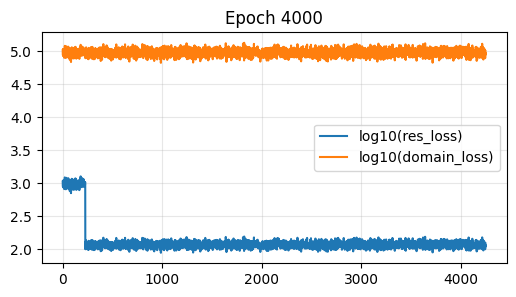

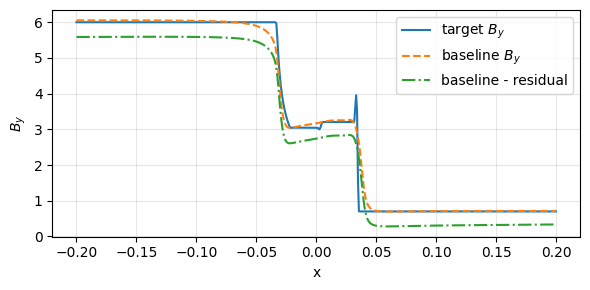

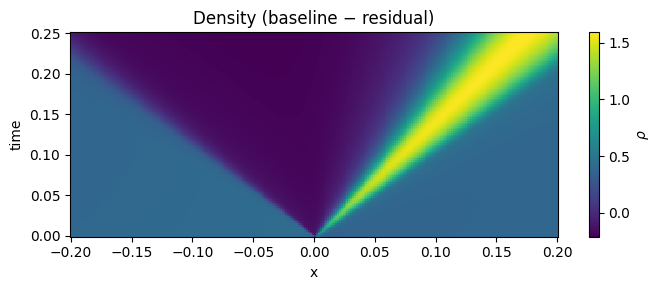

In [ ]:

if epoch % 50 == 0:
    # --- loss history (log scale) ---
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(np.log10(res_loss_history), label='log10(res_loss)')
    ax.plot(np.log10(domain_loss_history), label='log10(domain_loss)')
    ax.set_title(f'Epoch {epoch}')
    ax.grid(alpha=0.3)
    ax.legend()
    plt.show()

    # --- B_y cross-section at t = 0.036 ---
    t_vis = 0.036
    x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 512, device=DEVICE).unsqueeze(-1)
    coords_vis = torch.cat([x_vis, torch.full_like(x_vis, t_vis)], dim=1)
    with torch.no_grad():
        baseline = model(coords_vis)
        residual = model_residual(coords_vis)
        corrected = baseline - residual
        target = cond(t_vis, x_vis.squeeze(-1), device=DEVICE)

    x_cpu = x_vis.squeeze(-1).cpu().numpy()
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(x_cpu, target[:, 4].cpu(), label='target $B_y$')
    ax.plot(x_cpu, baseline[:, 4].cpu(), '--', label='baseline $B_y$')
    ax.plot(x_cpu, corrected[:, 4].cpu(), '-.', label='baseline - residual')
    ax.set_xlabel('x')
    ax.set_ylabel('$B_y$')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- density heatmap of baseline - residual ---
    times = torch.linspace(0.0, 0.25, 120, device=DEVICE)
    x_heat = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 256, device=DEVICE)
    rho_map = torch.empty(times.size(0), x_heat.size(0), device=DEVICE)
    with torch.no_grad():
        for i, t in enumerate(times):
            coords = torch.stack((x_heat, torch.full_like(x_heat, t)), dim=1)
            rho_map[i] = (model(coords) - model_residual(coords))[:, 0]
    fig, ax = plt.subplots(figsize=(7, 3))
    pcm = ax.pcolormesh(x_heat.cpu(), times.cpu(), rho_map.cpu(), shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax, label=r'$\rho$')
    ax.set_xlabel('x')
    ax.set_ylabel('time')
    ax.set_title('Density (baseline − residual)')
    plt.tight_layout()
    plt.show()



In [ ]:
lambda_time.keys()

dict_keys([0.0, 0.036, 0.1])

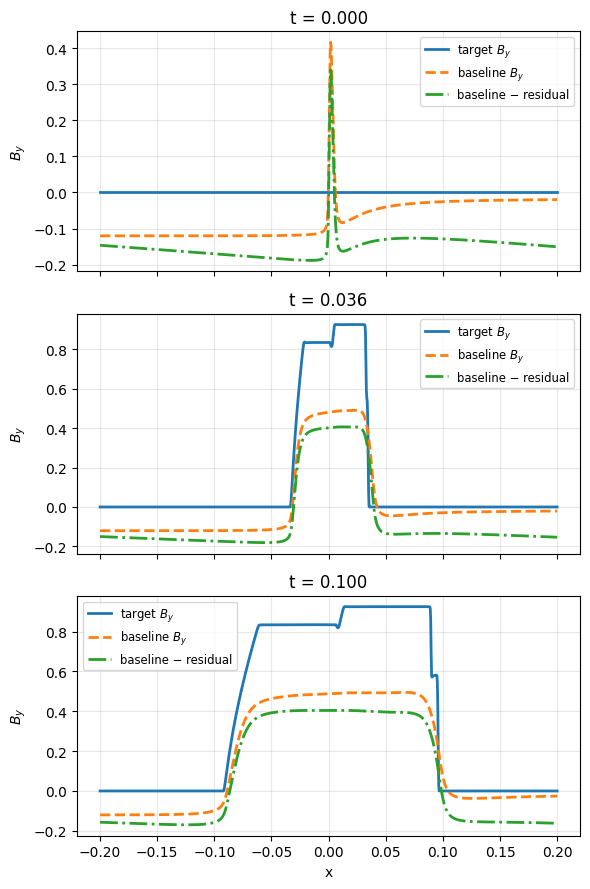

In [ ]:

# --- 2. B_y cross sections at the conditioned times ---
times_to_plot = sorted(([0.0, 0.036, 0.1]))           # e.g. [0.0, 0.036, 0.1]
n_vis = 1024
x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], n_vis, device=DEVICE).unsqueeze(-1)

fig, axes = plt.subplots(len(times_to_plot), 1, figsize=(6, 3*len(times_to_plot)), sharex=True)
axes = np.atleast_1d(axes)

with torch.no_grad():
    x_cpu = x_vis.squeeze(-1).cpu().numpy()

    for ax, t_val in zip(axes, times_to_plot):
        coords_vis = torch.cat([x_vis, torch.full_like(x_vis, t_val)], dim=1)
        baseline  = model(coords_vis)
        residual  = model_residual(coords_vis)
        corrected = baseline - residual
        target    = cond(t_val, x_vis.squeeze(-1), device=DEVICE)

        ax.plot(x_cpu, target[:, 1].cpu(), label='target $B_y$', lw=2)
        ax.plot(x_cpu, baseline[:, 1].cpu(), '--', label='baseline $B_y$', lw=2)
        ax.plot(x_cpu, corrected[:, 1].cpu(), '-.', label='baseline − residual', lw=2)
        ax.set_ylabel('$B_y$')
        ax.set_title(f't = {t_val:.3f}')
        ax.grid(alpha=0.3)
        ax.legend(fontsize='small')

axes[-1].set_xlabel('x')
plt.tight_layout()
plt.show()